# Load data

In [8]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
import torch.nn.functional as F
from fastshap import Surrogate, KLDivLoss
from aix360.metrics.local_metrics import faithfulness_metric

# Functions

In [52]:
# Faithfulness evaluation


class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.exp(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value=0.2):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness

# Experiments

In [2]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0
)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [3]:
# Select device
device = torch.device("cuda")
import dill

if os.path.isfile("./train_surrogate/surrogate_agosto.pt"):
    print("Loading saved surrogate model")
    surr = torch.load("./train_surrogate/surrogate_agosto.pt").to(device)
    surrogate = Surrogate(surr, num_features)

if os.path.isfile("./train_explainer/explainer_agosto.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_agosto.pt").to(device)
    fastshap = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

Loading saved surrogate model
Loading saved explainer model


In [4]:
# Select device
device = torch.device("cuda")
import dill

if os.path.isfile("./train_surrogate/surrogate_agosto_DP.pt"):
    print("Loading saved surrogate model")
    surr_DP = torch.load("./train_surrogate/surrogate_agosto_DP.pt").to(device)
    surrogate_DP = Surrogate(surr_DP, num_features)

if os.path.isfile("./train_explainer/explainer_agosto_DP.pt"):
    print("Loading saved explainer model")
    explainer_DP = torch.load("./train_explainer/explainer_agosto_DP.pt").to(device)
    fastshap_DP = FastSHAP(
        explainer_DP, surrogate_DP, normalization="additive", link=nn.Softmax(dim=-1)
    )

Loading saved surrogate model
Loading saved explainer model


# Comparison Plot PAIRED

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting function
def plot_shapley_comparison(evals, mean_distances, std_errors, title, log=False):
    plt.figure(figsize=(20, 8))
    for method, mean in mean_distances.items():
        std_error = std_errors[method]
        plt.plot(evals, mean, label=method)
        mean = np.array(mean)
        std_error = np.array(std_error)
        plt.fill_between(evals, mean - std_error, mean + std_error, alpha=0.2)

    plt.xlabel("# Evals", fontsize=20)
    plt.ylabel("Mean $\\ell_2$ distance", fontsize=20)
    plt.title(title, fontsize=20)
    # put the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)

    # set y lim
    # plt.ylim(0, 2)

    if log:
        plt.yscale("log")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True)
    plt.show()

In [ ]:
import dill

dumped_shap_values = dill.load(open("./shap_explanations/shap_values_paired.pkl", "rb"))
dumped_results = dill.load(open("./shap_explanations/results_paired.pkl", "rb"))
dumped_indexes = dill.load(open("./shap_explanations/indexes_paired.pkl", "rb"))
dumped_data = dill.load(open("./shap_explanations/data_paired.pkl", "rb"))
dumped_targets = dill.load(open("./shap_explanations/targets_paired.pkl", "rb"))

In [ ]:
true_shap = []
kernel = {}
fast = []
fast_DP = []

iters = [
    # 32,
    # 64,
    128,
    192,
    256,
    320,
    384,
    448,
    512,
    576,
    640,
    704,
    768,
    832,
    896,
    960,
    1024,
    1088,
    1152,
]

for index, (x, y) in enumerate(zip(dumped_data, dumped_targets)):
    fastshap_explanation = fastshap.shap_values(x)[0][:, y]
    fast.append(fastshap_explanation)

    fastshap_explanation_DP = fastshap_DP.shap_values(x)[0][:, y]
    fast_DP.append(fastshap_explanation_DP)

    true_shap_values = dumped_shap_values[index].values[:, y]
    true_shap.append(true_shap_values)

kernel_dict = {}
for index, explanation in enumerate(dumped_results):
    true_shap_values = dumped_shap_values[index].values[:, y]
    kernel_dict[index] = {}

    for it in iters:
        if it not in kernel_dict:
            kernel_dict[index][it] = {}
        if it in list(dumped_results[index]["iters"]):
            a = dumped_results[index]["values"][
                list(dumped_results[index]["iters"]).index(it)
            ][:, y]
            kernel_dict[index][it] = np.linalg.norm(a - true_shap_values)

In [ ]:
distances_fast = []
distances_fast_DP = []

std_fast = []
std_fast_DP = []

differences_kernel = {}
possible_it = []
differences_std = {}

for index in range(len(dumped_data)):
    true_values = true_shap[index]
    ff = fast[index]
    current_kernel = {}

    for a, b in zip(np.array(ff), np.array(true_values)):
        distances_fast.append(np.linalg.norm(a - b))

    ff_DP = fast_DP[index]
    for a, b in zip(np.array(ff_DP), np.array(true_values)):
        distances_fast_DP.append(np.linalg.norm(a - b))


for it in iters:
    differences_kernel[it] = []
    differences_std[it] = []
    for index in range(len(dumped_data)):
        if kernel_dict[index] and it in kernel_dict[index]:
            differences_kernel[it].append(kernel_dict[index][it])

    differences_kernel[it] = np.array(differences_kernel[it])
    differences_std[it] = sem(differences_kernel[it])
    # np.std(differences_kernel[it]) / np.sqrt(
    #     len(differences_kernel[it])
    # )
    differences_kernel[it] = np.mean(differences_kernel[it])

mean_fast = np.mean(distances_fast)
std_fast = sem(distances_fast)
print(mean_fast)
print(std_fast)

print(differences_kernel)
print(differences_std)

mean_fast_DP = np.mean(distances_fast_DP)
std_fast_DP = sem(distances_fast_DP)

results_mean = {
    "kernel_shap": [differences_kernel[it] for it in iters],
    "fastshap": [mean_fast] * len(iters),
}

results_std = {
    "kernel_shap": [differences_std[it] for it in iters],
    "fastshap": [std_fast] * len(iters),
}

In [ ]:
plot_shapley_comparison(iters, results_mean, results_std, "Adult")
plot_shapley_comparison(iters, results_mean, results_std, "Adult", log=True)

# Comparison Plot NOT PAIRED

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting function
def plot_shapley_comparison(evals, mean_distances, std_errors, title, log=False):
    plt.figure(figsize=(20, 8))
    for method, mean in mean_distances.items():
        std_error = std_errors[method]
        plt.plot(evals, mean, label=method)
        mean = np.array(mean)
        std_error = np.array(std_error)
        plt.fill_between(evals, mean - std_error, mean + std_error, alpha=0.2)

    plt.xlabel("# Evals", fontsize=20)
    plt.ylabel("Mean $\\ell_2$ distance", fontsize=20)
    plt.title(title, fontsize=20)
    # put the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)

    # log scale on y axis
    if log:
        plt.yscale("log")

    # set y lim
    # plt.ylim(0, 2)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True)
    plt.show()

In [ ]:
import dill

dumped_shap_values = dill.load(
    open("./shap_explanations/shap_values_NOT_paired.pkl", "rb")
)
dumped_results = dill.load(open("./shap_explanations/results_NOT_paired.pkl", "rb"))
dumped_indexes = dill.load(open("./shap_explanations/indexes_NOT_paired.pkl", "rb"))
dumped_data = dill.load(open("./shap_explanations/data_NOT_paired.pkl", "rb"))
dumped_targets = dill.load(open("./shap_explanations/targets_NOT_paired.pkl", "rb"))

In [ ]:
true_shap = []
kernel = {}
fast = []

iters = [
    # 32,
    # 64,
    128,
    192,
    256,
    320,
    384,
    448,
    512,
    576,
    640,
    704,
    768,
    832,
    896,
    960,
    1024,
    1088,
    1152,
]

for index, (x, y) in enumerate(zip(dumped_data, dumped_targets)):
    fastshap_explanation = fastshap.shap_values(x)[0][:, y]
    fast.append(fastshap_explanation)

    true_shap_values = dumped_shap_values[index].values[:, y]
    true_shap.append(true_shap_values)

kernel_dict = {}
for index, explanation in enumerate(dumped_results):
    true_shap_values = dumped_shap_values[index].values[:, y]
    kernel_dict[index] = {}

    for it in iters:
        if it in list(dumped_results[index]["iters"]):
            try:
                a = dumped_results[index]["values"][
                    list(dumped_results[index]["iters"]).index(it)
                ][:, y]
                if it not in kernel_dict:
                    kernel_dict[index][it] = {}
                kernel_dict[index][it] = np.linalg.norm(a - true_shap_values)
            except:
                continue

In [ ]:
distances_fast = []
std_fast = []
differences_kernel = {}
possible_it = []
differences_std = {}

for index in range(len(dumped_data)):
    true_values = true_shap[index]
    ff = fast[index]
    current_kernel = {}

    for a, b in zip(np.array(ff), np.array(true_values)):
        distances_fast.append(np.linalg.norm(a - b))


for it in iters:
    differences_kernel[it] = []
    differences_std[it] = []
    for index in range(len(dumped_data)):
        if kernel_dict[index] and it in kernel_dict[index]:
            differences_kernel[it].append(kernel_dict[index][it])

    differences_kernel[it] = np.array(differences_kernel[it])
    differences_std[it] = sem(differences_kernel[it])
    # np.std(differences_kernel[it]) / np.sqrt(
    #     len(differences_kernel[it])
    # )
    differences_kernel[it] = np.mean(differences_kernel[it])

mean_fast = np.mean(distances_fast)
std_fast = sem(distances_fast)  # np.std(distances_fast) / np.sqrt(len(distances_fast))
print(mean_fast)
print(std_fast)

print(differences_kernel)
print(differences_std)

results_mean = {
    "kernel_shap": [differences_kernel[it] for it in iters],
    "fastshap": [mean_fast] * len(iters),
}

results_std = {
    "kernel_shap": [differences_std[it] for it in iters],
    "fastshap": [std_fast] * len(iters),
}

In [ ]:
plot_shapley_comparison(iters, results_mean, results_std, "Adult")
plot_shapley_comparison(iters, results_mean, results_std, "Adult", log=True)

In [ ]:
# 0.0043010063578969296
# {128: 0.004181162203613906,

# Load data with DP

In [ ]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss

In [ ]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0
)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

In [ ]:
# Select device
device = torch.device("cuda")
import dill

if os.path.isfile("./train_surrogate/surrogate_agosto_DP.pt"):
    print("Loading saved surrogate model")
    surr_DP = torch.load("./train_surrogate/surrogate_agosto_DP.pt").to(device)
    surrogate_DP = Surrogate(surr_DP, num_features)

if os.path.isfile("./train_explainer/explainer_agosto_DP.pt"):
    print("Loading saved explainer model")
    explainer_DP = torch.load("./train_explainer/explainer_agosto_DP.pt").to(device)
    fastshap_DP = FastSHAP(
        explainer_DP, surrogate_DP, normalization="additive", link=nn.Softmax(dim=-1)
    )

# Comparison Plot PAIRED

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting function
def plot_shapley_comparison(evals, mean_distances, std_errors, title, log=False):
    plt.figure(figsize=(20, 8))
    for method, mean in mean_distances.items():
        std_error = std_errors[method]
        plt.plot(evals, mean, label=method)
        mean = np.array(mean)
        std_error = np.array(std_error)
        plt.fill_between(evals, mean - std_error, mean + std_error, alpha=0.2)

    plt.xlabel("# Evals", fontsize=20)
    plt.ylabel("Mean $\\ell_2$ distance", fontsize=20)
    plt.title(title, fontsize=20)
    # put the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)

    # set y lim
    # plt.ylim(0, 2)

    if log:
        plt.yscale("log")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True)
    plt.show()

In [ ]:
import dill

dumped_shap_values = dill.load(
    open("./shap_explanations/shap_values_paired_DP.pkl", "rb")
)
dumped_results = dill.load(open("./shap_explanations/results_paired_DP.pkl", "rb"))
dumped_indexes = dill.load(open("./shap_explanations/indexes_paired_DP.pkl", "rb"))
dumped_data = dill.load(open("./shap_explanations/data_paired_DP.pkl", "rb"))
dumped_targets = dill.load(open("./shap_explanations/targets_paired_DP.pkl", "rb"))

In [ ]:
true_shap = []
kernel = {}
fast = []
fast_DP = []

iters = [
    # 32,
    # 64,
    128,
    192,
    256,
    320,
    384,
    448,
    512,
    576,
    640,
    704,
    768,
    832,
    896,
    960,
    1024,
    1088,
    1152,
]

for index, (x, y) in enumerate(zip(dumped_data, dumped_targets)):
    fastshap_explanation_DP = fastshap_DP.shap_values(x)[0][:, y]
    fast_DP.append(fastshap_explanation_DP)

    true_shap_values = dumped_shap_values[index].values[:, y]
    true_shap.append(true_shap_values)

kernel_dict = {}
for index, explanation in enumerate(dumped_results):
    true_shap_values = dumped_shap_values[index].values[:, y]
    kernel_dict[index] = {}

    for it in iters:
        if it not in kernel_dict:
            kernel_dict[index][it] = {}
        if it in list(dumped_results[index]["iters"]):
            a = dumped_results[index]["values"][
                list(dumped_results[index]["iters"]).index(it)
            ][:, y]
            kernel_dict[index][it] = np.linalg.norm(a - true_shap_values)

In [ ]:
distances_fast_DP = []

std_fast_DP = []

differences_kernel = {}
possible_it = []
differences_std = {}

for index in range(len(dumped_data)):
    true_values = true_shap[index]
    current_kernel = {}

    ff_DP = fast_DP[index]
    for a, b in zip(np.array(ff_DP), np.array(true_values)):
        distances_fast_DP.append(np.linalg.norm(a - b))


for it in iters:
    differences_kernel[it] = []
    differences_std[it] = []
    for index in range(len(dumped_data)):
        if kernel_dict[index] and it in kernel_dict[index]:
            differences_kernel[it].append(kernel_dict[index][it])

    differences_kernel[it] = np.array(differences_kernel[it])
    differences_std[it] = sem(differences_kernel[it])

    differences_kernel[it] = np.mean(differences_kernel[it])


print(differences_kernel)
print(differences_std)

mean_fast_DP = np.mean(distances_fast_DP)
std_fast_DP = sem(distances_fast_DP)

results_mean = {
    "kernel_shap": [differences_kernel[it] for it in iters],
    "fastshap DP": [mean_fast_DP] * len(iters),
}

results_std = {
    "kernel_shap": [differences_std[it] for it in iters],
    "fastshap DP": [std_fast_DP] * len(iters),
}

In [ ]:
plot_shapley_comparison(iters, results_mean, results_std, "Adult")
plot_shapley_comparison(iters, results_mean, results_std, "Adult", log=True)

# Comparison Plot NOT PAIRED

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting function
def plot_shapley_comparison(evals, mean_distances, std_errors, title, log=False):
    plt.figure(figsize=(20, 8))
    for method, mean in mean_distances.items():
        std_error = std_errors[method]
        plt.plot(evals, mean, label=method)
        mean = np.array(mean)
        std_error = np.array(std_error)
        plt.fill_between(evals, mean - std_error, mean + std_error, alpha=0.2)

    plt.xlabel("# Evals", fontsize=20)
    plt.ylabel("Mean $\\ell_2$ distance", fontsize=20)
    plt.title(title, fontsize=20)
    # put the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)

    # set y lim
    # plt.ylim(0, 2)
    if log:
        plt.yscale("log")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True)
    plt.show()

In [ ]:
import dill

dumped_shap_values = dill.load(
    open("./shap_explanations/shap_values_NOT_paired_DP.pkl", "rb")
)
dumped_results = dill.load(open("./shap_explanations/results_NOT_paired_DP.pkl", "rb"))
dumped_indexes = dill.load(open("./shap_explanations/indexes_NOT_paired_DP.pkl", "rb"))
dumped_data = dill.load(open("./shap_explanations/data_NOT_paired_DP.pkl", "rb"))
dumped_targets = dill.load(open("./shap_explanations/targets_NOT_paired_DP.pkl", "rb"))

In [ ]:
true_shap = []
kernel = {}
fast = []

iters = [
    # 32,
    # 64,
    128,
    192,
    256,
    320,
    384,
    448,
    512,
    576,
    640,
    704,
    768,
    832,
    896,
    960,
    1024,
    1088,
    1152,
]

for index, (x, y) in enumerate(zip(dumped_data, dumped_targets)):
    true_shap_values = dumped_shap_values[index].values[:, y]
    true_shap.append(true_shap_values)

kernel_dict = {}
for index, explanation in enumerate(dumped_results):
    true_shap_values = dumped_shap_values[index].values[:, y]
    kernel_dict[index] = {}

    for it in iters:
        if it in list(dumped_results[index]["iters"]):
            try:
                a = dumped_results[index]["values"][
                    list(dumped_results[index]["iters"]).index(it)
                ][:, y]
                if it not in kernel_dict:
                    kernel_dict[index][it] = {}
                kernel_dict[index][it] = np.linalg.norm(a - true_shap_values)
            except:
                continue

In [ ]:
distances_fast = []
differences_kernel = {}
possible_it = []
differences_std = {}


for it in iters:
    differences_kernel[it] = []
    differences_std[it] = []
    for index in range(len(dumped_data)):
        if kernel_dict[index] and it in kernel_dict[index]:
            differences_kernel[it].append(kernel_dict[index][it])

    differences_kernel[it] = np.array(differences_kernel[it])
    differences_std[it] = sem(differences_kernel[it])
    # np.std(differences_kernel[it]) / np.sqrt(
    #     len(differences_kernel[it])
    # )
    differences_kernel[it] = np.mean(differences_kernel[it])


print(differences_kernel)
print(differences_std)

results_mean = {
    "kernel_shap": [differences_kernel[it] for it in iters],
    "fastshap DP": [mean_fast_DP] * len(iters),
}

results_std = {
    "kernel_shap": [differences_std[it] for it in iters],
    "fastshap DP": [std_fast_DP] * len(iters),
}

In [ ]:
plot_shapley_comparison(iters, results_mean, results_std, "Adult")
plot_shapley_comparison(iters, results_mean, results_std, "Adult", log=True)

# Fastshap vs FastShap with DP

Calcolo la distanza tra le spiegazioni di Fastshap senza DP e le spiegazioni di Fastshap con la DP. Non ho calcolato la distanza tra i true shap values e le spiegazioni di Fastshap con DP perchè i true shap values sono calcolati senza DP durante la spiegazione, non credo che sarebbe un confronto corretto.

In [15]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss

In [16]:
# Faithfulness evaluation
from aix360.metrics.local_metrics import faithfulness_metric
import torch.nn.functional as F


class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.exp(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value=0.2):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0
)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
# Select device
device = torch.device("cuda")
import dill

# Fastshap senza Privacy
if os.path.isfile("./train_surrogate/surrogate_agosto.pt"):
    print("Loading saved surrogate model")
    surr = torch.load("./train_surrogate/surrogate_agosto.pt").to(device)
    surrogate = Surrogate(surr, num_features)

if os.path.isfile("./train_explainer/explainer_agosto.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_agosto.pt").to(device)
    fastshap = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

if os.path.isfile("./train_model/model_no_dp.pth"):
    print("Loading saved model")
    model = torch.load("./train_model/model_no_dp.pth")
    model_no_dp_aix = aix_model(model)

# Fastshap con Privacy 1.0

if os.path.isfile("./train_surrogate/surrogate_agosto_DP.pt"):
    print("Loading saved surrogate model")
    surr_DP_1 = torch.load("./train_surrogate/surrogate_agosto_DP.pt").to(device)
    surrogate_DP_1 = Surrogate(surr_DP_1, num_features)

if os.path.isfile("./train_explainer/explainer_agosto_DP.pt"):
    print("Loading saved explainer model")
    explainer_DP_1 = torch.load("./train_explainer/explainer_agosto_DP.pt").to(device)
    fastshap_DP_1 = FastSHAP(
        explainer_DP_1,
        surrogate_DP_1,
        normalization="additive",
        link=nn.Softmax(dim=-1),
    )

if os.path.isfile("./train_model/model_agosto_DP_1.pth"):
    print("Loading saved model")
    model = torch.load("./train_model/model_agosto_DP_1.pth")
    model_dp_1_aix = aix_model(model)

# Fastshap con Privacy 0.5

if os.path.isfile("./train_surrogate/surrogate_agosto_DP_05.pt"):
    print("Loading saved surrogate model")
    surr_DP_05 = torch.load("./train_surrogate/surrogate_agosto_DP_05.pt").to(device)
    surrogate_DP_05 = Surrogate(surr_DP_05, num_features)

if os.path.isfile("./train_explainer/explainer_agosto_DP_05.pt"):
    print("Loading saved explainer model")
    explainer_DP_05 = torch.load("./train_explainer/explainer_agosto_DP_05.pt").to(
        device
    )
    fastshap_DP_05 = FastSHAP(
        explainer_DP_05,
        surrogate_DP_05,
        normalization="additive",
        link=nn.Softmax(dim=-1),
    )

if os.path.isfile("./train_model/model_agosto_DP_05.pth"):
    print("Loading saved model")
    model = torch.load("./train_model/model_agosto_DP_05.pth")
    model_dp_05_aix = aix_model(model)

# Fastshap con Privacy 5

if os.path.isfile("./train_surrogate/surrogate_agosto_DP_5.pt"):
    print("Loading saved surrogate model")
    surr_DP_5 = torch.load("./train_surrogate/surrogate_agosto_DP_5.pt").to(device)
    surrogate_DP_5 = Surrogate(surr_DP_5, num_features)

if os.path.isfile("./train_explainer/explainer_agosto_DP_5.pt"):
    print("Loading saved explainer model")
    explainer_DP_5 = torch.load("./train_explainer/explainer_agosto_DP_5.pt").to(device)
    fastshap_DP_5 = FastSHAP(
        explainer_DP_5,
        surrogate_DP_5,
        normalization="additive",
        link=nn.Softmax(dim=-1),
    )

if os.path.isfile("./train_model/model_agosto_DP_5.pth"):
    print("Loading saved model")
    model = torch.load("./train_model/model_agosto_DP_5.pth")
    model_dp_5_aix = aix_model(model)

Loading saved surrogate model
Loading saved explainer model
Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved model


In [19]:
fast = []
fast_1 = []
fast_05 = []
fast_5 = []

faithfulness_no_dp = []
faithfulness_eps_1 = []
faithfulness_eps_05 = []
faithfulness_eps_5 = []

for index, (x, y) in enumerate(zip(X_test, Y_test)):
    y = 0 if not y else 1
    x = np.array([list(x)])

    fastshap_explanation = fastshap.shap_values(x)[0][:, y]
    fast.append(fastshap_explanation)

    faithfulness_no_dp.append(
        compute_faithfulness(
            x, y, fastshap_explanation, model_no_dp_aix, base_value=0.001
        )
    )

    fastshap_explanation_DP_05 = fastshap_DP_05.shap_values(x)[0][:, y]
    fast_05.append(fastshap_explanation_DP_05)

    faithfulness_eps_05.append(
        compute_faithfulness(
            x, y, fastshap_explanation_DP_05, model_dp_05_aix, base_value=0.001
        )
    )

    fastshap_explanation_DP_1 = fastshap_DP_1.shap_values(x)[0][:, y]
    fast_1.append(fastshap_explanation_DP_1)

    faithfulness_eps_1.append(
        compute_faithfulness(
            x, y, fastshap_explanation_DP_1, model_dp_1_aix, base_value=0.001
        )
    )

    fastshap_explanation_DP_5 = fastshap_DP_5.shap_values(x)[0][:, y]
    fast_5.append(fastshap_explanation_DP_5)

    faithfulness_eps_5.append(
        compute_faithfulness(
            x, y, fastshap_explanation_DP_5, model_dp_5_aix, base_value=0.001
        )
    )

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
distances_fast_DP_1 = []
std_fast_DP_1 = []

distances_fast_DP_05 = []
std_fast_DP_05 = []

distances_fast_DP_5 = []
std_fast_DP_5 = []

for index in range(len(X_test)):
    ff_DP = fast_05[index]
    for a, b in zip(np.array(ff_DP), np.array(fast)):
        distances_fast_DP_05.append(np.linalg.norm(a - b))

    ff_DP = fast_1[index]
    for a, b in zip(np.array(ff_DP), np.array(fast)):
        distances_fast_DP_1.append(np.linalg.norm(a - b))

    ff_DP = fast_5[index]
    for a, b in zip(np.array(ff_DP), np.array(fast)):
        distances_fast_DP_5.append(np.linalg.norm(a - b))

In [ ]:
results_mean = {
    # "fastshap": [mean_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [np.mean(distances_fast_DP_05)],
    "fastshap DP - Epsilon 1": [np.mean(distances_fast_DP_1)],
    "fastshap DP - Epsilon 5": [np.mean(distances_fast_DP_5)],
}

results_std = {
    # "fastshap": [std_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [np.std(distances_fast_DP_05)],
    "fastshap DP - Epsilon 1": [np.std(distances_fast_DP_1)],
    "fastshap DP - Epsilon 5": [np.std(distances_fast_DP_5)],
}

In [ ]:
# plot_shapley_comparison(iters, results_mean, results_std, "Adult")
# plot_shapley_comparison(iters, results_mean, results_std, "Adult", log=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the means and standard errors
labels = list(results_mean.keys())
means = [results_mean[label][0] for label in labels]
errors = [results_std[label][0] for label in labels]

# Plotting
plt.figure(figsize=(8, 6))

# Use different markers for each point
markers = ["o", "s", "^"]

for i, label in enumerate(labels):
    plt.errorbar(
        i,
        means[i],
        yerr=errors[i],
        fmt=markers[i],
        label=label,
        capsize=5,
        markersize=10,
    )

# Customizing the plot
plt.xticks(range(len(labels)), labels, fontsize=12)
plt.ylabel("Mean Distance", fontsize=14)
plt.title(
    "Mean Distance with Standard Deviation for Different Epsilon Values", fontsize=16
)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

# DUTCH Fastshap vs FastShap with DP 

Calcolo la distanza tra le spiegazioni di Fastshap senza DP e le spiegazioni di Fastshap con la DP. Non ho calcolato la distanza tra i true shap values e le spiegazioni di Fastshap con DP perchè i true shap values sono calcolati senza DP durante la spiegazione, non credo che sarebbe un confronto corretto.

In [ ]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss
from utils import prepare_data
from scipy.stats import spearmanr

In [ ]:
class Args:
    def __init__(self):
        self.dataset_name = "adult"
        self.sweep = True


args = Args()
args.dataset_name = "dutch"
(
    train_set,
    val_set,
    test_set,
    X_train,
    X_val,
    X_test,
    Y_train,
    Y_val,
    Y_test,
    num_features,
    feature_names,
) = prepare_data(args)


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Select device
device = torch.device("cuda")
import dill

# Fastshap No Privacy
if os.path.isfile("./train_surrogate/surrogate_dutch_NO_DP.pt"):
    print("Loading saved surrogate model")
    surr = torch.load("./train_surrogate/surrogate_dutch_NO_DP.pt").to(device)
    surrogate = Surrogate(surr, num_features)

if os.path.isfile("./train_explainer/explainer_dutch_NO_DP.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_NO_DP.pt").to(device)
    fastshap = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

if os.path.isfile("./train_dutch/model_dutch_NO_DP.pth"):
    print("Loading saved model")
    model_no_dp = torch.load("./train_dutch/model_dutch_NO_DP.pth").to("cpu")
    model_no_dp_aix = aix_model(model_no_dp)


# Fastshap with DP Eps 1

if os.path.isfile("./train_surrogate/surrogate_dutch_DP_1_nuovo.pt"):
    print("Loading saved surrogate model")
    surr_DP_1 = torch.load("./train_surrogate/surrogate_dutch_DP_1_nuovo.pt").to(device)
    surrogate_DP_1 = Surrogate(surr_DP_1, num_features)

if os.path.isfile("./train_explainer/explainer_dutch_DP_1_nuovo.pt"):
    print("Loading saved explainer model")
    explainer_DP_1 = torch.load("./train_explainer/explainer_dutch_DP_1_nuovo.pt").to(
        device
    )
    fastshap_DP_1 = FastSHAP(
        explainer_DP_1,
        surrogate_DP_1,
        normalization="additive",
        link=nn.Softmax(dim=-1),
    )

if os.path.isfile("./train_dutch/model_agosto_DP_1.pth"):
    print("Loading saved model")
    model_eps_1 = torch.load("./train_dutch/model_agosto_DP_1.pth").to("cpu")
    model_eps_1_aix = aix_model(model_eps_1)

# Fastshap with DP Eps 0.5

if os.path.isfile("./train_surrogate/surrogate_DP_05_dutch.pt"):
    print("Loading saved surrogate model")
    surr_DP_05 = torch.load("./train_surrogate/surrogate_DP_05_dutch.pt").to(device)
    surrogate_DP_05 = Surrogate(surr_DP_05, num_features)

if os.path.isfile("./train_explainer/explainer_dutch_DP_05.pt"):
    print("Loading saved explainer model")
    explainer_DP_05 = torch.load("./train_explainer/explainer_dutch_DP_05.pt").to(
        device
    )
    fastshap_DP_05 = FastSHAP(
        explainer_DP_05,
        surrogate_DP_05,
        normalization="additive",
        link=nn.Softmax(dim=-1),
    )


if os.path.isfile("./train_dutch/model_agosto_DP_05.pth"):
    print("Loading saved model")
    model_eps_05 = torch.load("./train_dutch/model_agosto_DP_05.pth").to("cpu")
    model_eps_05_aix = aix_model(model_eps_1)

# Fastshap with DP Eps 5

if os.path.isfile("./train_surrogate/surrogate_DP_5_dutch.pt"):
    print("Loading saved surrogate model")
    surr_DP_5 = torch.load("./train_surrogate/surrogate_DP_5_dutch.pt").to(device)
    surrogate_DP_5 = Surrogate(surr_DP_5, num_features)

if os.path.isfile("./train_explainer/explainer_dutch_DP_5.pt"):
    print("Loading saved explainer model")
    explainer_DP_5 = torch.load("./train_explainer/explainer_dutch_DP_5.pt").to(device)
    fastshap_DP_5 = FastSHAP(
        explainer_DP_5,
        surrogate_DP_5,
        normalization="additive",
        link=nn.Softmax(dim=-1),
    )

if os.path.isfile("./train_dutch/model_agosto_DP_5.pth"):
    print("Loading saved model")
    model_eps_5 = torch.load("./train_dutch/model_agosto_DP_5.pth").to("cpu")
    model_eps_5_aix = aix_model(model_eps_1)

Loading saved surrogate model
Loading saved explainer model
Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved model


In [ ]:
fast = []
fast_1 = []
fast_05 = []
fast_5 = []

faithfulness_no_dp = []
faithfulness_eps_1 = []
faithfulness_eps_05 = []
faithfulness_eps_5 = []

for index, (x, y) in enumerate(zip(X_test, Y_test)):
    y = 0 if not y else 1
    x = np.array([list(x)])

    fastshap_explanation = fastshap.shap_values(x)[0][:, y]
    fast.append(fastshap_explanation)
    faithfulness_no_dp.append(
        compute_faithfulness(
            x, y, fastshap_explanation, model_no_dp_aix, base_value=0.001
        )
    )

    fastshap_explanation_DP_05 = fastshap_DP_05.shap_values(x)[0][:, y]
    fast_05.append(fastshap_explanation_DP_05)
    faithfulness_eps_05.append(
        compute_faithfulness(
            x, y, fastshap_explanation, model_eps_05_aix, base_value=0.001
        )
    )

    fastshap_explanation_DP_1 = fastshap_DP_1.shap_values(x)[0][:, y]
    fast_1.append(fastshap_explanation_DP_1)
    faithfulness_eps_1.append(
        compute_faithfulness(
            x, y, fastshap_explanation, model_eps_1_aix, base_value=0.001
        )
    )

    fastshap_explanation_DP_5 = fastshap_DP_5.shap_values(x)[0][:, y]
    fast_5.append(fastshap_explanation_DP_5)
    faithfulness_eps_5.append(
        compute_faithfulness(
            x, y, fastshap_explanation, model_eps_5_aix, base_value=0.001
        )
    )

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
distances_fast_DP_1 = []
std_fast_DP_1 = []

spearman_1 = []
spearman_05 = []
spearman_5 = []

cos_sim_05 = []
cos_sim_1 = []
cos_sim_5 = []

distances_fast_DP_05 = []
std_fast_DP_05 = []

distances_fast_DP_5 = []
std_fast_DP_5 = []

for index in range(len(X_test)):
    ff_DP = fast_05[index]
    ff = fast[index]

    # for a, b in zip(np.array(ff_DP), np.array(ff)):
    distances_fast_DP_05.append(np.linalg.norm(ff_DP - ff))

    coef, p = spearmanr(ff_DP, ff)
    spearman_05.append(coef)

    cos_sim_05.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))

    ff_DP = fast_1[index]
    distances_fast_DP_1.append(np.linalg.norm(ff_DP - ff))
    coef, p = spearmanr(ff_DP, ff)
    spearman_1.append(coef)

    cos_sim_1.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))

    ff_DP = fast_5[index]
    distances_fast_DP_5.append(np.linalg.norm(ff_DP - ff))
    coef, p = spearmanr(ff_DP, ff)
    spearman_5.append(coef)

    cos_sim_5.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))

In [ ]:
results_mean = {
    # "fastshap": [mean_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [np.mean(distances_fast_DP_05)],
    "fastshap DP - Epsilon 1": [np.mean(distances_fast_DP_1)],
    "fastshap DP - Epsilon 5": [np.mean(distances_fast_DP_5)],
}

results_std = {
    # "fastshap": [std_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [sem(distances_fast_DP_05)],
    "fastshap DP - Epsilon 1": [sem(distances_fast_DP_1)],
    "fastshap DP - Epsilon 5": [sem(distances_fast_DP_5)],
}

In [ ]:
spearman_mean = {
    # "fastshap": [mean_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [np.mean(spearman_05)],
    "fastshap DP - Epsilon 1": [np.mean(spearman_1)],
    "fastshap DP - Epsilon 5": [np.mean(spearman_5)],
}

spearman_std = {
    # "fastshap": [std_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [sem(spearman_05)],
    "fastshap DP - Epsilon 1": [sem(spearman_1)],
    "fastshap DP - Epsilon 5": [sem(spearman_5)],
}

In [ ]:
cosine_mean = {
    # "fastshap": [mean_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [np.mean(cos_sim_05)],
    "fastshap DP - Epsilon 1": [np.mean(cos_sim_1)],
    "fastshap DP - Epsilon 5": [np.mean(cos_sim_5)],
}

cosine_std = {
    # "fastshap": [std_fast] * len(iters),
    "fastshap DP - Epsilon 0.5": [sem(cos_sim_05)],
    "fastshap DP - Epsilon 1": [sem(cos_sim_1)],
    "fastshap DP - Epsilon 5": [sem(cos_sim_5)],
}

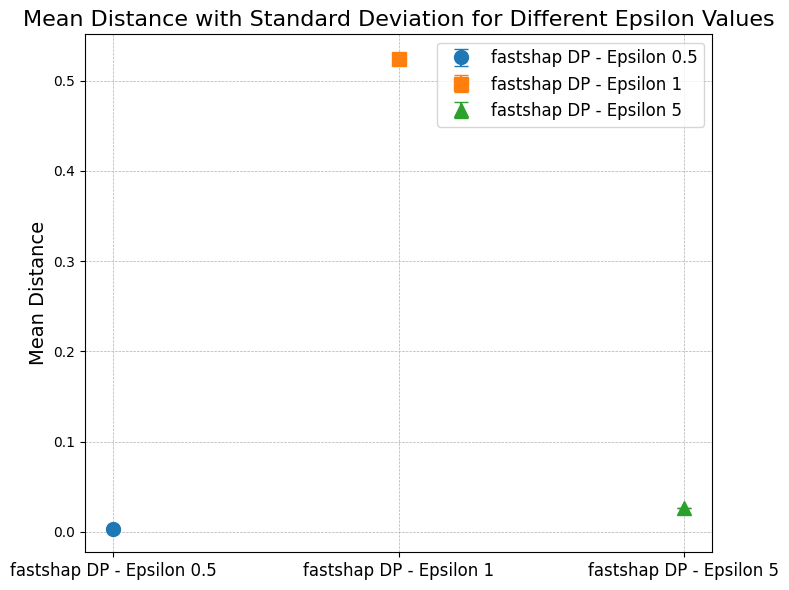

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the means and standard errors
labels = list(results_mean.keys())
means = [results_mean[label][0] for label in labels]
errors = [results_std[label][0] for label in labels]

# Plotting
plt.figure(figsize=(8, 6))

# Use different markers for each point
markers = ["o", "s", "^"]

for i, label in enumerate(labels):
    plt.errorbar(
        i,
        means[i],
        yerr=errors[i],
        fmt=markers[i],
        label=label,
        capsize=5,
        markersize=10,
    )

# Customizing the plot
plt.xticks(range(len(labels)), labels, fontsize=12)
plt.ylabel("Mean Distance", fontsize=14)
plt.title(
    "Mean Distance with Standard Deviation for Different Epsilon Values", fontsize=16
)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

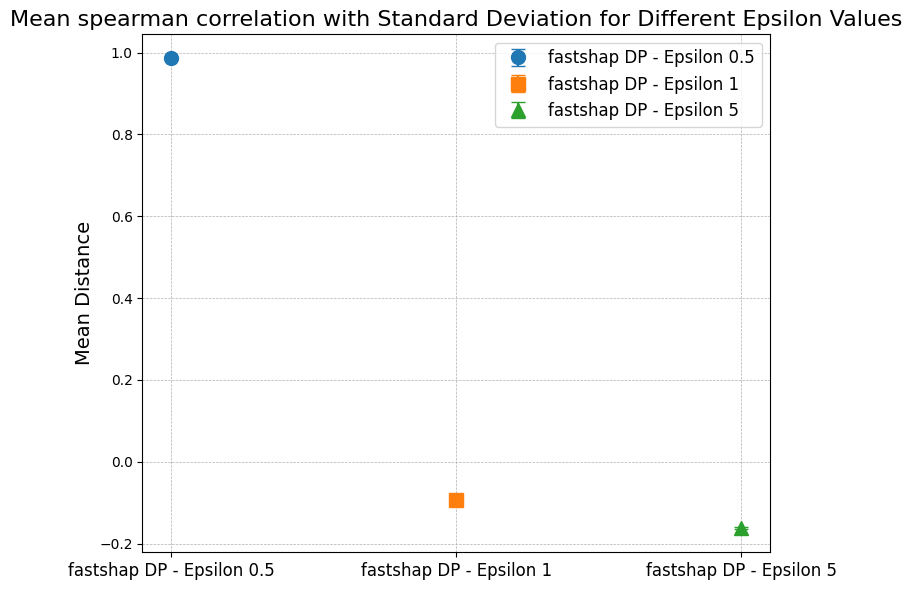

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the means and standard errors
labels = list(spearman_mean.keys())
means = [spearman_mean[label][0] for label in labels]
errors = [spearman_std[label][0] for label in labels]

# Plotting
plt.figure(figsize=(8, 6))

# Use different markers for each point
markers = ["o", "s", "^"]

for i, label in enumerate(labels):
    plt.errorbar(
        i,
        means[i],
        yerr=errors[i],
        fmt=markers[i],
        label=label,
        capsize=5,
        markersize=10,
    )

# Customizing the plot
plt.xticks(range(len(labels)), labels, fontsize=12)
plt.ylabel("Mean Distance", fontsize=14)
plt.title(
    "Mean spearman correlation with Standard Deviation for Different Epsilon Values",
    fontsize=16,
)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

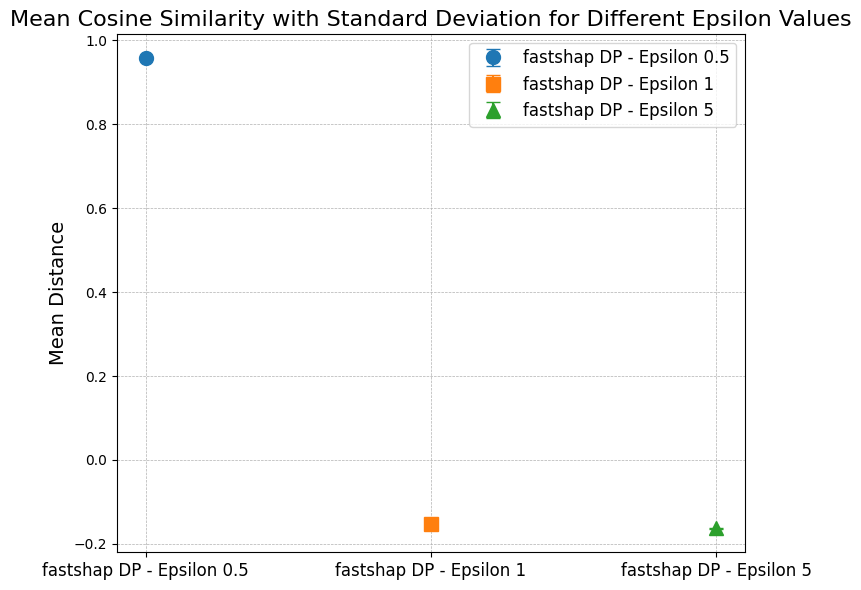

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the means and standard errors
labels = list(cosine_mean.keys())
means = [cosine_mean[label][0] for label in labels]
errors = [cosine_std[label][0] for label in labels]

# Plotting
plt.figure(figsize=(8, 6))

# Use different markers for each point
markers = ["o", "s", "^"]

for i, label in enumerate(labels):
    plt.errorbar(
        i,
        means[i],
        yerr=errors[i],
        fmt=markers[i],
        label=label,
        capsize=5,
        markersize=10,
    )

# Customizing the plot
plt.xticks(range(len(labels)), labels, fontsize=12)
plt.ylabel("Mean Distance", fontsize=14)
plt.title(
    "Mean Cosine Similarity with Standard Deviation for Different Epsilon Values",
    fontsize=16,
)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
def plot_faithfulness(
    faithfulness_no_dp, faithfulness_eps_05, faithfulness_eps_1, faithfulness_eps_5
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = sem(faithfulness_no_dp)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = sem(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = sem(faithfulness_eps_1)

    mean_eps_5 = np.mean(faithfulness_eps_5)
    std_eps_5 = sem(faithfulness_eps_5)

    results_mean = {
        "No DP": [mean_no_dp],
        "Eps. 1.5": [mean_eps_05],
        "Eps. 3": [mean_eps_1],
        "Eps. 15": [mean_eps_5],
    }

    results_std = {
        "No DP": [std_no_dp],
        "Eps. 1.5": [std_eps_05],
        "Eps. 3": [std_eps_1],
        "Eps. 15": [std_eps_5],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()


def plot_faithfulness_std_dev(
    faithfulness_no_dp, faithfulness_eps_05, faithfulness_eps_1, faithfulness_eps_5
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = np.std(faithfulness_no_dp)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = np.std(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = np.std(faithfulness_eps_1)

    mean_eps_5 = np.mean(faithfulness_eps_5)
    std_eps_5 = np.std(faithfulness_eps_5)

    results_mean = {
        "No DP": [mean_no_dp],
        "Eps. 1.5": [mean_eps_05],
        "Eps. 3": [mean_eps_1],
        "Eps. 15": [mean_eps_5],
    }

    results_std = {
        "No DP": [std_no_dp],
        "Eps. 1.5": [std_eps_05],
        "Eps. 3": [std_eps_1],
        "Eps. 15": [std_eps_5],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()

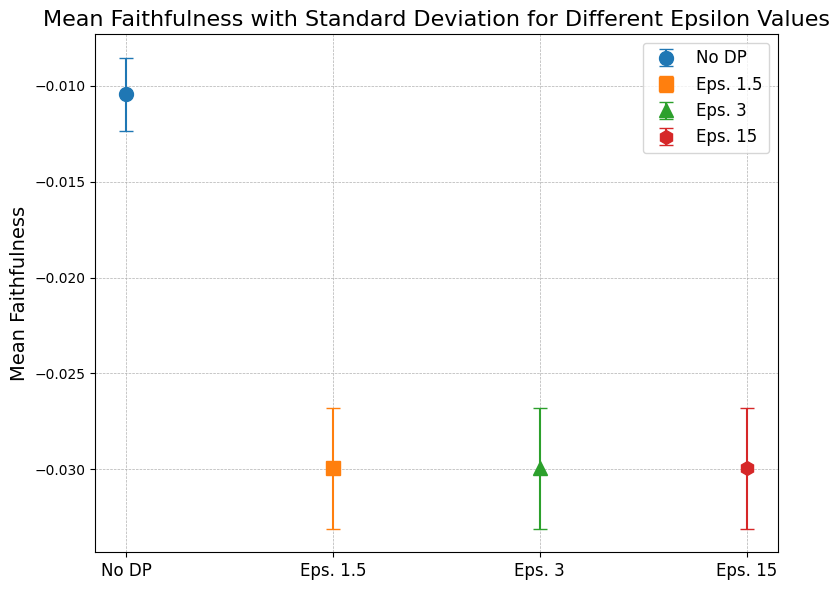

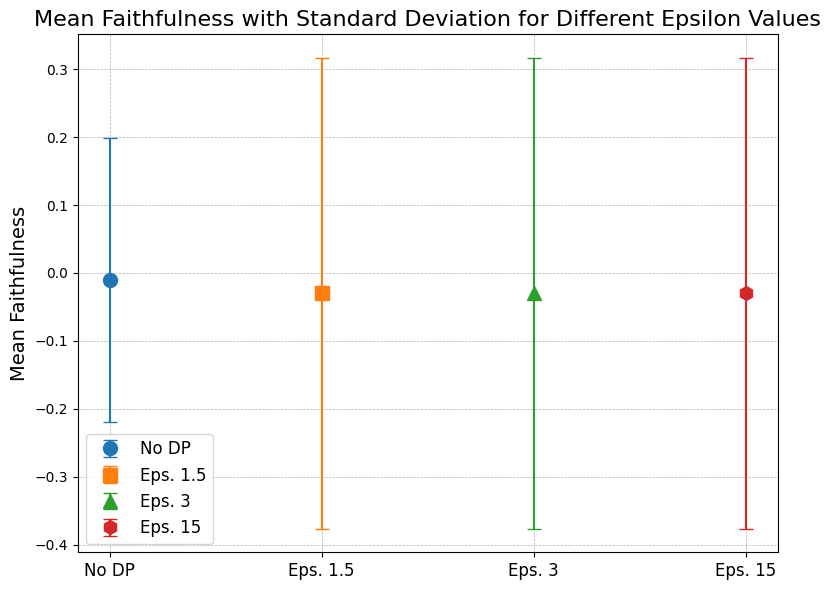

In [ ]:
plot_faithfulness(
    faithfulness_no_dp, faithfulness_eps_05, faithfulness_eps_1, faithfulness_eps_5
)

plot_faithfulness_std_dev(
    faithfulness_no_dp, faithfulness_eps_05, faithfulness_eps_1, faithfulness_eps_5
)